In [49]:
import sys

#comment this, these two lines are for local python installation
sys.path.append('/home/zinovyev/anaconda3/lib/python3.7/site-packages')
sys.path.append('/mnt/c/MyPrograms/__github/DAPCA')

import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.io import savemat
from scipy.io import loadmat
from numpy import genfromtxt
from DAPCA import DAPCA
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import scipy.io
import scipy.linalg
from timeit import default_timer as timer
from datetime import timedelta
import random
from scipy.io import loadmat
from sklearn.svm import SVC
import random
from random import sample



def space_alignment(X,Y,Subspace_Dim,normalize=True):
    if normalize:
        Xz = stats.zscore((X.T/np.sum(X,axis=1)).T)
        Yz = stats.zscore((Y.T/np.sum(Y,axis=1)).T)
    else:
        Xz = X
        Yz = Y
    pcaX = PCA()
    pcaX.fit(Xz)
    VX = pcaX.components_.T
    pcaY = PCA()
    pcaY.fit(Yz)
    VY = pcaY.components_.T
    if Subspace_Dim>VX.shape[1]:
        Subspace_Dim = VX.shape[1]
    if Subspace_Dim>VY.shape[1]:
        Subspace_Dim = VY.shape[1]
    VX = VX[:,:Subspace_Dim]
    VY = VY[:,:Subspace_Dim]
    Xpa = Xz@(VX@VX.T@VY)
    Ypa = Yz@VY
    return [Xpa,Ypa]

# This TCA implementation is taken from https://github.com/jindongwang/transferlearning
class TCA:
    dim = 5
    kerneltype = 'rbf'
    kernelparam = 1
    mu = 1

    def __init__(self, dim=5, kerneltype='rbf', kernelparam=1, mu=1):
        '''
        Init function
        :param dim: dims after tca (dim <= d)
        :param kerneltype: 'rbf' | 'linear' | 'poly' (default is 'rbf')
        :param kernelparam: kernel param
        :param mu: param
        '''
        self.dim = dim
        self.kernelparam = kernelparam
        self.kerneltype = kerneltype
        self.mu = mu

    def get_L(self, n_src, n_tar):
        '''
        Get index matrix
        :param n_src: num of source domain 
        :param n_tar: num of target domain
        :return: index matrix L
        '''
        L_ss = (1. / (n_src * n_src)) * np.full((n_src, n_src), 1)
        L_st = (-1. / (n_src * n_tar)) * np.full((n_src, n_tar), 1)
        L_ts = (-1. / (n_tar * n_src)) * np.full((n_tar, n_src), 1)
        L_tt = (1. / (n_tar * n_tar)) * np.full((n_tar, n_tar), 1)
        L_up = np.hstack((L_ss, L_st))
        L_down = np.hstack((L_ts, L_tt))
        L = np.vstack((L_up, L_down))
        return L

    def get_kernel(self, kerneltype, kernelparam, x1, x2=None):
        '''
        Calculate kernel for TCA (inline func)
        :param kerneltype: 'rbf' | 'linear' | 'poly'
        :param kernelparam: param
        :param x1: x1 matrix (n1,d)
        :param x2: x2 matrix (n2,d)
        :return: Kernel K
        '''
        n1, dim = x1.shape
        K = None
        if x2 is not None:
            n2 = x2.shape[0]
        if kerneltype == 'linear':
            if x2 is not None:
                K = np.dot(x2, x1.T)
            else:
                K = np.dot(x1, x1.T)
        elif kerneltype == 'poly':
            if x2 is not None:
                K = np.power(np.dot(x1, x2.T), kernelparam)
            else:
                K = np.power(np.dot(x1, x1.T), kernelparam)
        elif kerneltype == 'rbf':
            if x2 is not None:
                sum_x2 = np.sum(np.multiply(x2, x2), axis=1)
                sum_x2 = sum_x2.reshape((len(sum_x2), 1))
                K = np.exp(-1 * (
                    np.tile(np.sum(np.multiply(x1, x1), axis=1).T, (n2, 1)) + np.tile(sum_x2, (1, n1)) - 2 * np.dot(x2,
                                                                                                                    x1.T)) / (
                               dim * 2 * kernelparam))
            else:
                P = np.sum(np.multiply(x1, x1), axis=1)
                P = P.reshape((len(P), 1))
                K = np.exp(
                    -1 * (np.tile(P.T, (n1, 1)) + np.tile(P, (1, n1)) - 2 * np.dot(x1, x1.T)) / (dim * 2 * kernelparam))
        # more kernels can be added
        return K

    def fit_transform(self, x_src, x_tar, x_tar_o=None):
        '''
        TCA main method. Wrapped from Sinno J. Pan and Qiang Yang's "Domain adaptation via transfer component ayalysis. IEEE TNN 2011" 
        :param x_src: Source domain data feature matrix. Shape is (n_src,d)
        :param x_tar: Target domain data feature matrix. Shape is (n_tar,d)
        :param x_tar_o: Out-of-sample target data feature matrix. Shape is (n_tar_o,d)
        :return: tranformed x_src_tca,x_tar_tca,x_tar_o_tca
        '''
        n_src = x_src.shape[0]
        n_tar = x_tar.shape[0]
        X = np.vstack((x_src, x_tar))
        L = self.get_L(n_src, n_tar)
        L[np.isnan(L)] = 0
        K = self.get_kernel(self.kerneltype, self.kernelparam, X)
        K[np.isnan(K)] = 0
        if x_tar_o is not None:
            K_tar_o = self.get_kernel(self.kerneltype, self.kernelparam, X, x_tar_o)

        H = np.identity(n_src + n_tar) - 1. / (n_src + n_tar) * np.ones(shape=(n_src + n_tar, 1)) * np.ones(
            shape=(n_src + n_tar, 1)).T
        forPinv = self.mu * np.identity(n_src + n_tar) + np.dot(np.dot(K, L), K)
        forPinv[np.isnan(forPinv)] = 0
        Kc = np.dot(np.dot(np.dot(np.linalg.pinv(forPinv), K), H), K)
        Kc[np.isnan(Kc)] = 0

        print('Computing eigen vectors...',Kc.shape)
        D, V = np.linalg.eig(Kc)
        eig_values = D.reshape(len(D), 1)
        eig_values_sorted = np.sort(eig_values[::-1], axis=0)
        index_sorted = np.argsort(-eig_values, axis=0)
        V = V[:, index_sorted]
        V = V.reshape((V.shape[0], V.shape[1]))
        x_src_tca = np.dot(K[:n_src, :], V)
        x_tar_tca = np.dot(K[n_src:, :], V)
        if x_tar_o is not None:
            x_tar_o_tca = np.dot(K_tar_o, V)
        else:
            x_tar_o_tca = None

        x_src_tca = np.asarray(x_src_tca[:, :self.dim], dtype=float)
        x_tar_tca = np.asarray(x_tar_tca[:, :self.dim], dtype=float)
        if x_tar_o is not None:
            x_tar_o_tca = x_tar_o_tca[:, :self.dim]
        return x_src_tca, x_tar_tca, x_tar_o_tca

def whiten(X,eps=1e-10):
    # the matrix X should be observations-by-components
    # get the covariance matrix
    Xcov = np.dot(X.T,X)+eps*np.eye(X.shape[1])
    # eigenvalue decomposition of the covariance matrix
    d, V = np.linalg.eigh(Xcov)
    # a fudge factor can be used so that eigenvectors associated with
    # small eigenvalues do not get overamplified.
    #D = np.diag(1. / np.sqrt(d+fudge))
    D = np.diag(1. / np.sqrt(d))
    # whitening matrix
    W = np.dot(np.dot(V, D), V.T)
    # multiply by the whitening matrix
    X_white = np.dot(X, W)
    scale = np.sqrt(np.trace(np.cov(X_white.T))/X.shape[1])
    X_white = X_white/scale
    return X_white, W

def CORAL(Xs,Xt,eps=1e-10):
    #Xw, _ = whiten(Xs,eps=eps)
    cov_source = np.cov(Xs.T) + eps*np.eye(Xs.shape[1])
    cov_target = np.cov(Xt.T) + eps*np.eye(Xt.shape[1])
    Xs_coral = np.real(Xs@np.linalg.inv(scipy.linalg.sqrtm(cov_source))@scipy.linalg.sqrtm(cov_target))
    return Xs_coral

def print_accuracies(X,labels,Y,target_labels,method_name):
    clf = KNeighborsClassifier(n_neighbors=1)
    clf.fit(X, labels)
    y_pred = clf.predict(Y)
    acc = sklearn.metrics.accuracy_score(target_labels, y_pred)
    print('Accuracy of '+method_name+'(kNN)=',acc)
    acc = sklearn.metrics.balanced_accuracy_score(target_labels, y_pred)
    print('Balanced accuracy of '+method_name+'(kNN)=',acc)
    clf = SVC(gamma='auto',C=1)
    clf.fit(X, labels)
    y_pred = clf.predict(Y)
    acc = sklearn.metrics.accuracy_score(target_labels, y_pred)
    print('Accuracy of '+method_name+'(SVC)=',acc)
    acc = sklearn.metrics.balanced_accuracy_score(target_labels, y_pred)
    print('Balanced accuracy of '+method_name+'(SVC)=',acc)

    
def rand_rotation_matrix(deflection=1.0, randnums=None):
    """
    Creates a random rotation matrix.
    
    deflection: the magnitude of the rotation. For 0, no rotation; for 1, competely random
    rotation. Small deflection => small perturbation.
    randnums: 3 random numbers in the range [0, 1]. If `None`, they will be auto-generated.
    """
    # from http://www.realtimerendering.com/resources/GraphicsGems/gemsiii/rand_rotation.c
    
    if randnums is None:
        randnums = np.random.uniform(size=(3,))
        
    theta, phi, z = randnums
    
    theta = theta * 2.0*deflection*np.pi  # Rotation about the pole (Z).
    phi = phi * 2.0*np.pi  # For direction of pole deflection.
    z = z * 2.0*deflection  # For magnitude of pole deflection.
    
    # Compute a vector V used for distributing points over the sphere
    # via the reflection I - V Transpose(V).  This formulation of V
    # will guarantee that if x[1] and x[2] are uniformly distributed,
    # the reflected points will be uniform on the sphere.  Note that V
    # has length sqrt(2) to eliminate the 2 in the Householder matrix.
    
    r = np.sqrt(z)
    Vx, Vy, Vz = V = (
        np.sin(phi) * r,
        np.cos(phi) * r,
        np.sqrt(2.0 - z)
        )
    
    st = np.sin(theta)
    ct = np.cos(theta)
    
    R = np.array(((ct, st, 0), (-st, ct, 0), (0, 0, 1)))
    
    # Construct the rotation matrix  ( V Transpose(V) - I ) R.
    
    M = (np.outer(V, V) - np.eye(3)).dot(R)
    return M


In [8]:
configuration = '2clusters_3d'

n_points = [1000,1000]
n_pointsY = [1000,200]

# for the paper
mean1 = np.array([0,2,0])
cov1 = np.array([[1,0,0],[0,5,0],[0,0,10]])
mean2 = np.array([5,-5,0])
cov2 = cov1 
mean1Y = np.array([0,30,0])
cov1Y = cov1*2
mean2Y = np.array([5,10,0])
cov2Y = cov2

mean1 = np.array([0,2,0])
cov1 = np.array([[1,0,0],[0,5,0],[0,0,10]])
mean2 = np.array([5,-5,0])
cov2 = cov1 
mean1Y = np.array([0,30,0])
cov1Y = cov1*2
mean2Y = np.array([5,10,0])
cov2Y = cov2

pop_size = 30000
XX1 = np.random.multivariate_normal(mean1, cov1, size=pop_size)
XX2 = np.random.multivariate_normal(mean2, cov2, size=pop_size)
YY1 = np.random.multivariate_normal(mean1Y, cov1Y, size=pop_size)
YY2 = np.random.multivariate_normal(mean2Y, cov2Y, size=pop_size)

X1 = XX1[sample(range(pop_size),n_points[0]),:]
X2 = XX2[sample(range(pop_size),n_points[1]),:]
Y1 = YY1[sample(range(pop_size),n_pointsY[0]),:]
Y2 = YY2[sample(range(pop_size),n_pointsY[1]),:]

X = np.concatenate([X1,X2])
X1 = X - np.mean(X,axis=0)
Y = np.concatenate([Y1,Y2])
Y = Y - np.mean(X,axis=0)
X = X1

XY = np.concatenate([X,Y])

do_rotation = True
#Rotation of everything by some arbitraty angle
if do_rotation:
    M = rand_rotation_matrix(randnums=(0.3,0.8,0.3))
    XY = (M@XY.T).T
    X = XY[:X.shape[0],:]
    Y = XY[X.shape[0]:,:]

labels = np.concatenate([np.ones(n_points[0])*1,np.ones(n_points[1])*2])
known_labels = np.concatenate([np.ones(n_pointsY[0])*1,np.ones(n_pointsY[1])*2])
target_labels = known_labels
labelsXY = np.concatenate([labels,-1*np.ones(np.sum(n_pointsY))])

np.savetxt(configuration+'_X.csv',X,fmt='%3.3f',delimiter=',')
np.savetxt(configuration+'_labels.csv',labels,fmt='%i',delimiter=',')
np.savetxt(configuration+'_Y.csv',Y,fmt='%3.3f',delimiter=',')
np.savetxt(configuration+'_target_labels.csv',known_labels,fmt='%i',delimiter=',')


In [31]:
# one can start from the saved data
configuration = '2clusters_3d'
X = genfromtxt(configuration+'_X.csv', delimiter=',')
labels = genfromtxt(configuration+'_labels.csv', delimiter=',').astype(np.int32)
Y = genfromtxt(configuration+'_Y.csv', delimiter=',')
target_labels = genfromtxt(configuration+'_target_labels.csv', delimiter=',').astype(np.int32)

Accuracy of PCA(kNN)= 0.8866666666666667
Balanced accuracy of PCA(kNN)= 0.9319999999999999
Accuracy of PCA(SVC)= 0.74
Balanced accuracy of PCA(SVC)= 0.464


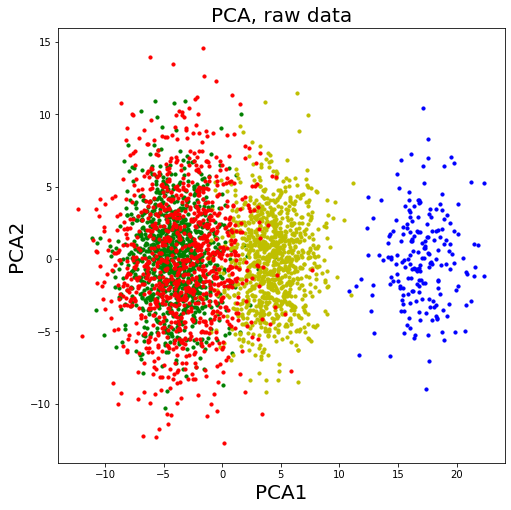

Time to compute SA: 0:00:00.001388
Accuracy of SA(kNN)= 0.8883333333333333
Balanced accuracy of SA(kNN)= 0.933
Accuracy of SA(SVC)= 0.7183333333333334
Balanced accuracy of SA(SVC)= 0.439


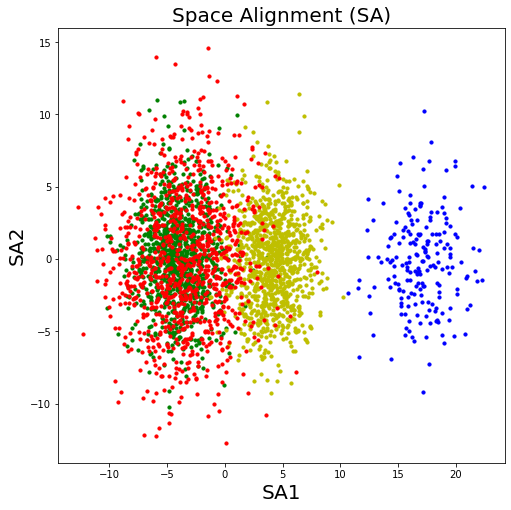

In [85]:
point_size = 10

ind1 = np.where(labels==1)[0]
ind2 = np.where(labels==2)[0]
target_ind1 = np.where(target_labels==1)[0]
target_ind2 = np.where(target_labels==2)[0]

#Xn = stats.zscore(X)
#Yn = stats.zscore(Y)
Xn = X-np.mean(X,axis=0)
Yn = Y-np.mean(Y,axis=0)


pca = PCA()
Xp = pca.fit_transform(np.concatenate([Xn,Yn]))
XpX = Xp[:X.shape[0],:]
XpY = Xp[X.shape[0]:,:]

print_accuracies(XpX,labels,XpY,target_labels,'PCA')

plt.figure(figsize=(8,8))
plt.scatter(XpX[ind1,0],XpX[ind1,1],c='g',s=point_size)
plt.scatter(XpX[ind2,0],XpX[ind2,1],c='y',s=point_size)
plt.scatter(XpY[target_ind1,0],XpY[target_ind1,1],c='r',s=point_size)
plt.scatter(XpY[target_ind2,0],XpY[target_ind2,1],c='b',s=point_size)
#plt.title('PCA before space alignment, raw data',fontsize=20)
plt.title('PCA, raw data',fontsize=20)
plt.xlabel('PCA1',fontsize=20)
plt.ylabel('PCA2',fontsize=20)
plt.show()

start = timer()
[Xpa,Ypa] = space_alignment(Xn,Yn,2,normalize=False)
end = timer()
print('Time to compute SA:',timedelta(seconds=end-start))

print_accuracies(Xpa,labels,Ypa,target_labels,'SA')

plt.figure(figsize=(8,8))
plt.scatter(Xpa[ind1,0],Xpa[ind1,1],c='g',s=point_size)
plt.scatter(Xpa[ind2,0],Xpa[ind2,1],c='y',s=point_size)
plt.scatter(Ypa[target_ind1,0],Ypa[target_ind1,1],c='r',s=point_size)
plt.scatter(Ypa[target_ind2,0],Ypa[target_ind2,1],c='b',s=point_size)
plt.xlabel('SA1',fontsize=20)
plt.ylabel('SA2',fontsize=20)
#plt.title('Space Alignment, acc={:2.2f}'.format(acc),fontsize=20)
plt.title('Space Alignment (SA)',fontsize=20)
#plt.axis('equal')
plt.show()

Iteration: 0 non-neg: 0 Hw: -1797.1010772437007
Iteration: 1 non-neg: 0 Hw diff: -63.324894501307796 (-27.937878346728787)
Iteration: 2 non-neg: 1 Hw diff: -0.17333447623222606 (-23.810668579723323)
Iteration: 3 non-neg: 1 Hw diff: -0.13326623131004917 (-21.010657444719172)
Iteration: 4 non-neg: 1 Hw diff: -0.10457815219174736 (-19.021431306629594)
Iteration: 5 non-neg: 1 Hw diff: -0.088143100156447 (-17.480634030482573)
Iteration: 6 non-neg: 1 Hw diff: -0.06930600529675476 (-16.34764412047918)
Iteration: 7 non-neg: 1 Hw diff: -0.053856794521097456 (-15.512206407425609)
Iteration: 8 non-neg: 1 Hw diff: -0.04380187233614916 (-14.861255587430112)
Iteration: 9 non-neg: 1 Hw diff: -0.03432641867296904 (-14.368051824971232)
Time to compute DAPCA: 0:00:01.102792
Accuracy of DAPCA(kNN)= 0.9633333333333334
Balanced accuracy of DAPCA(kNN)= 0.978


/mnt/c/MyPrograms/__github/DAPCA/DAPCA.py:618: UserWarning: All eigenvalues starting from 1 are negative
  warnings.warn(f"All eigenvalues starting from {ind} are negative")


Accuracy of DAPCA(SVC)= 0.9591666666666666
Balanced accuracy of DAPCA(SVC)= 0.9735


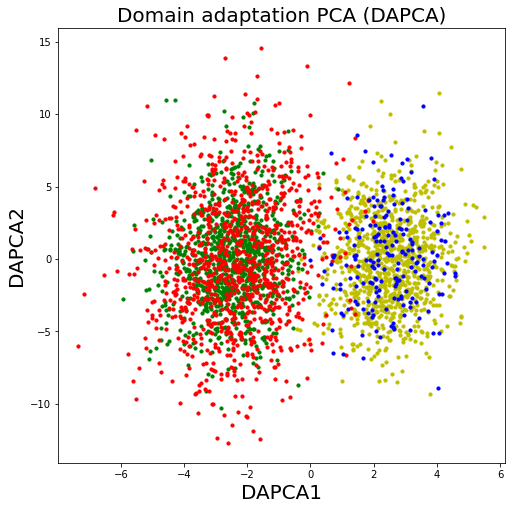

Iteration: 0 non-neg: 2 Hw: 154.7314007194037
Time to compute STCA: 0:00:01.372493
Accuracy of STCA(kNN)= 0.8941666666666667


/mnt/c/MyPrograms/__github/DAPCA/DAPCA.py:387: UserWarning: TCA is used and DAPCA parameters are ignored
  warnings.warn("TCA is used and DAPCA parameters are ignored")


Balanced accuracy of STCA(kNN)= 0.9365
Accuracy of STCA(SVC)= 0.7325
Balanced accuracy of STCA(SVC)= 0.4555


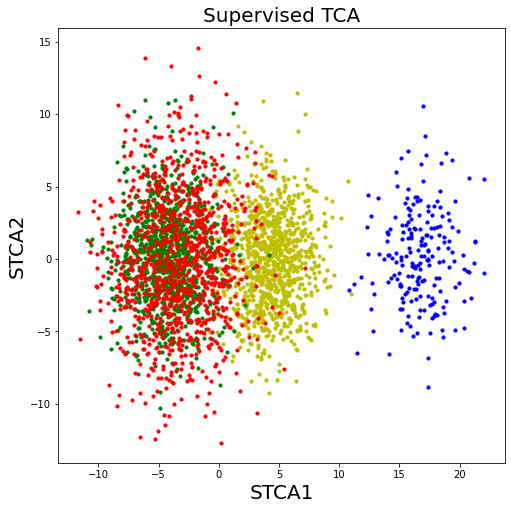

In [80]:
point_size = 10

ind1 = np.where(labels==1)[0]
ind2 = np.where(labels==2)[0]
target_ind1 = np.where(target_labels==1)[0]
target_ind2 = np.where(target_labels==2)[0]

# ======================= PARAMETERS OF DAPCA ===========================
alpha = 1
gamma = 100
maxIter = 10
beta = 1
kNN = 10
num_comps = 2
# =======================================================================

pca = PCA(svd_solver='full')
u = pca.fit_transform(X)
mn = np.mean(X,axis=0)
PY = pca.fit_transform(Y)

start = timer()
[V1, D1, PX, PY, kNNs] = DAPCA(X, labels, num_comps,  YY=Y, 
                         alpha=alpha, gamma=gamma,maxIter=maxIter, 
                        beta=beta,verbose='all',kNN=kNN,
                              eps=1e-10) 

end = timer()
print('Time to compute DAPCA:',timedelta(seconds=end-start))

print_accuracies(PX,labels,PY,target_labels,'DAPCA')

plt.figure(figsize=(8,8))
plt.scatter(PX[ind2,0],PX[ind2,1],c='y',s=point_size)
plt.scatter(PX[ind1,0],PX[ind1,1],c='g',s=point_size)
plt.scatter(PY[target_ind1,0],PY[target_ind1,1],c='r',s=point_size)
plt.scatter(PY[target_ind2,0],PY[target_ind2,1],c='b',s=point_size)
plt.xlabel('DAPCA1',fontsize=20)
plt.ylabel('DAPCA2',fontsize=20)
#plt.title('Domain adaptation PCA, acc={:2.2f}'.format(acc),fontsize=20)
plt.title('Domain adaptation PCA (DAPCA)',fontsize=20)
plt.show()

### NOW DAPCA in the mode of SUPERVISED TCA

[V1, D1, PXtca, PYtca, kNNs] = DAPCA(Xn, labels, num_comps,  YY=Yn, 
                         alpha=alpha, gamma=gamma,maxIter=maxIter, 
                        beta=beta,verbose='all',kNN=kNN,tca=1,
                              eps=1e-10) 

end = timer()
print('Time to compute STCA:',timedelta(seconds=end-start))

print_accuracies(PXtca,labels,PYtca,target_labels,'STCA')

plt.figure(figsize=(8,8))
plt.scatter(PXtca[ind2,0],PXtca[ind2,1],c='y',s=point_size)
plt.scatter(PXtca[ind1,0],PXtca[ind1,1],c='g',s=point_size)
plt.scatter(PYtca[target_ind1,0],PYtca[target_ind1,1],c='r',s=point_size)
plt.scatter(PYtca[target_ind2,0],PYtca[target_ind2,1],c='b',s=point_size)
plt.xlabel('STCA1',fontsize=20)
plt.ylabel('STCA2',fontsize=20)
#plt.xlim([-5,5])
#plt.ylim([-5,5])
#plt.axis('equal')
plt.title('Supervised TCA',fontsize=20)
plt.show()

Computing eigen vectors... (3200, 3200)


/home/zinovyev/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Time to compute TCA1: 0:00:42.565201
Accuracy of TCA(kNN)= 0.8733333333333333
Balanced accuracy of TCA(kNN)= 0.9239999999999999
Accuracy of TCA(SVC)= 0.815
Balanced accuracy of TCA(SVC)= 0.5409999999999999


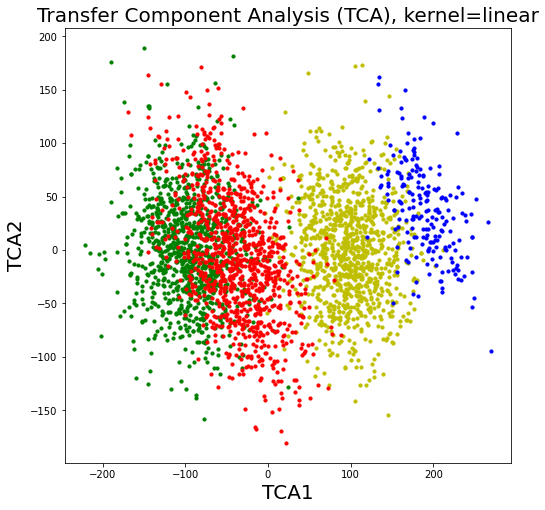

In [87]:
Xn = stats.zscore(X)
Yn = stats.zscore(Y)
#Xn = X-np.mean(X,axis=0)
#Yn = Y-np.mean(Y,axis=0)


subsample_size = -1

if subsample_size>0:
    ind_selectX = sorted(random.sample(set(np.arange(Xn.shape[0])),subsample_size))
    ind_selectY = sorted(random.sample(set(np.arange(Yn.shape[0])),subsample_size))
    Xss = Xn[ind_selectX,:]
    Yss = Yn[ind_selectY,:]
    labels_ss = labels[ind_selectX]
    target_labels_ss = target_labels[ind_selectY]
else:
    Xss = Xn
    Yss = Yn
    labels_ss = labels
    target_labels_ss = target_labels
    
ind1 = np.where(labels_ss==1)[0]
ind2 = np.where(labels_ss==2)[0]
target_ind1 = np.where(target_labels_ss==1)[0]
target_ind2 = np.where(target_labels_ss==2)[0]

kernel_type = 'linear'
#kernel_type = 'rbf'

start = timer()
my_tca = TCA(dim=2,kerneltype=kernel_type)
Xtca, Ytca, _ = my_tca.fit_transform(Xss, Yss)
end = timer()
print('Time to compute TCA1:',timedelta(seconds=end-start))

print_accuracies(Xtca,labels,Ytca,target_labels,'TCA')

ind1 = np.where(labels_ss==1)[0]
ind2 = np.where(labels_ss==2)[0]
target_ind1 = np.where(target_labels_ss==1)[0]
target_ind2 = np.where(target_labels_ss==2)[0]

plt.figure(figsize=(8,8))
plt.scatter(Xtca[ind2,0],Xtca[ind2,1],c='y',s=point_size)
plt.scatter(Xtca[ind1,0],Xtca[ind1,1],c='g',s=point_size)
plt.scatter(Ytca[target_ind1,0],Ytca[target_ind1,1],c='r',s=point_size)
plt.scatter(Ytca[target_ind2,0],Ytca[target_ind2,1],c='b',s=point_size)
plt.xlabel('TCA1',fontsize=20)
plt.ylabel('TCA2',fontsize=20)
#plt.xlim([-5,5])
#plt.ylim([-5,5])
#plt.axis('equal')
#plt.title('Transfer Component Analysis, acc={:2.2f}'.format(acc),fontsize=20)
plt.title('Transfer Component Analysis (TCA), kernel='+kernel_type,fontsize=20)
plt.show()

Accuracy of Baseline(kNN)= 0.8866666666666667
Balanced accuracy of Baseline(kNN)= 0.9319999999999999
Accuracy of Baseline(SVC)= 0.74
Balanced accuracy of Baseline(SVC)= 0.464
Accuracy of PCA(kNN)= 0.8841666666666667
Balanced accuracy of PCA(kNN)= 0.9305
Accuracy of PCA(SVC)= 0.7325
Balanced accuracy of PCA(SVC)= 0.4575


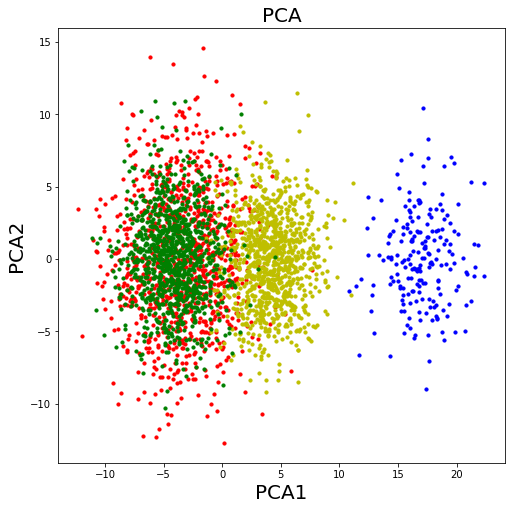

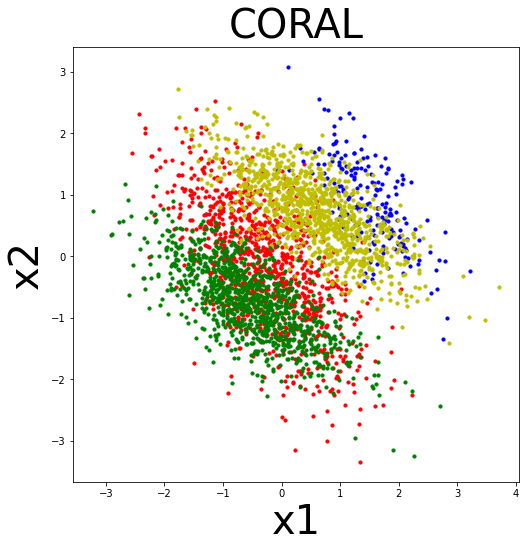

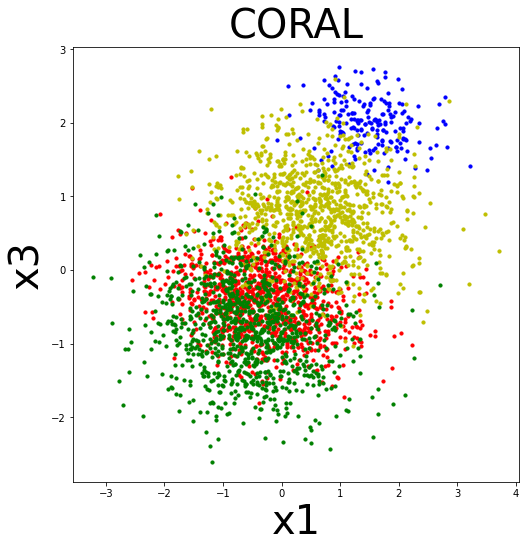

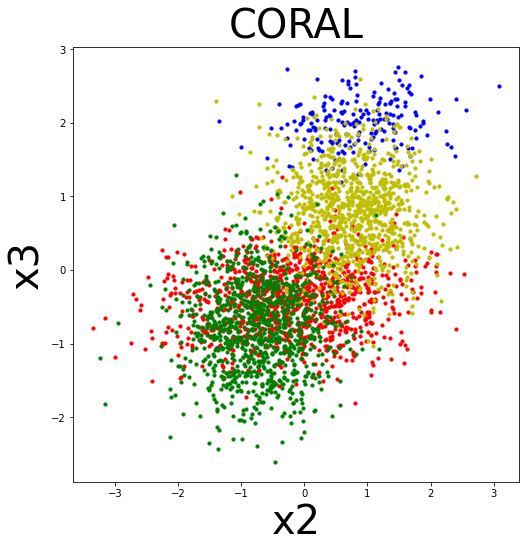

Accuracy of Full CORAL(kNN)= 0.7916666666666666
Balanced accuracy of Full CORAL(kNN)= 0.875
Accuracy of Full CORAL(SVC)= 0.8116666666666666
Balanced accuracy of Full CORAL(SVC)= 0.887
Accuracy of PCA CORAL(kNN)= 0.8641666666666666
Balanced accuracy of PCA CORAL(kNN)= 0.9185
Accuracy of PCA CORAL(SVC)= 0.86
Balanced accuracy of PCA CORAL(SVC)= 0.9159999999999999


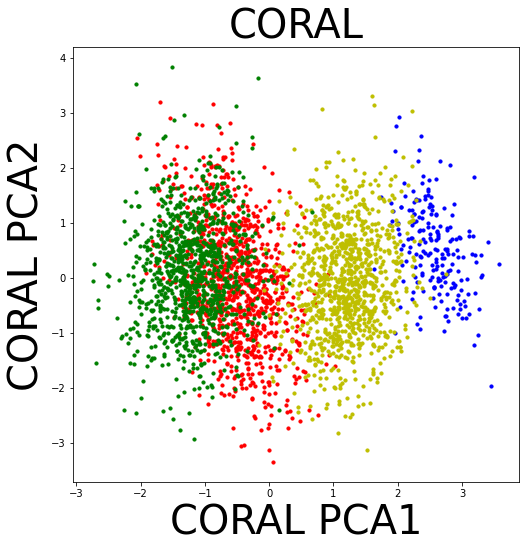

In [90]:
ind1 = np.where(labels==1)[0]
ind2 = np.where(labels==2)[0]
target_ind1 = np.where(target_labels==1)[0]
target_ind2 = np.where(target_labels==2)[0]

#Xn = stats.zscore(X)
#Yn = stats.zscore(Y)
Xn = X-np.mean(X,axis=0)
Yn = Y-np.mean(Y,axis=0)

print_accuracies(Xn,labels,Yn,target_labels,'Baseline')

pca = PCA(n_components=2)
Xp = pca.fit_transform(np.concatenate([Xn,Yn]))
XpX = Xp[:X.shape[0],:]
XpY = Xp[X.shape[0]:,:]

print_accuracies(XpX,labels,XpY,target_labels,'PCA')

plt.figure(figsize=(8,8))
plt.scatter(XpY[target_ind1,0],XpY[target_ind1,1],c='r',s=point_size)
plt.scatter(XpY[target_ind2,0],XpY[target_ind2,1],c='b',s=point_size)
plt.scatter(XpX[ind2,0],XpX[ind2,1],c='y',s=point_size)
plt.scatter(XpX[ind1,0],XpX[ind1,1],c='g',s=point_size)
plt.xlabel('PCA1',fontsize=20)
plt.ylabel('PCA2',fontsize=20)
#plt.xlim([-5,5])
#plt.ylim([-5,5])
plt.title('PCA',fontsize=20)
#plt.axis('equal')
plt.show()

Xn = stats.zscore(X)
Yn = stats.zscore(Y)
X_coral = CORAL(Xn,Yn,eps=1)
# This is CORAL computed using MATLAB (done for making sure Python code gives the same result)
# X_coral = np.loadtxt('2clusters_3d_X_coral.csv',delimiter=',')

plt.figure(figsize=(8,8))
plt.scatter(Yn[target_ind1,0],Yn[target_ind1,1],c='r',s=point_size)
plt.scatter(Yn[target_ind2,0],Yn[target_ind2,1],c='b',s=point_size)
plt.scatter(X_coral[ind2,0],X_coral[ind2,1],c='y',s=point_size)
plt.scatter(X_coral[ind1,0],X_coral[ind1,1],c='g',s=point_size)
plt.xlabel('x1',fontsize=40)
plt.ylabel('x2',fontsize=40)
#plt.xlim([-5,5])
#plt.ylim([-5,5])
#plt.title('CORAL, acc={:2.2f}'.format(acc),fontsize=20)
plt.title('CORAL',fontsize=40)
#plt.axis('equal')
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(Yn[target_ind1,0],Yn[target_ind1,2],c='r',s=point_size)
plt.scatter(Yn[target_ind2,0],Yn[target_ind2,2],c='b',s=point_size)
plt.scatter(X_coral[ind2,0],X_coral[ind2,2],c='y',s=point_size)
plt.scatter(X_coral[ind1,0],X_coral[ind1,2],c='g',s=point_size)
plt.xlabel('x1',fontsize=40)
plt.ylabel('x3',fontsize=40)
#plt.xlim([-5,5])
#plt.ylim([-5,5])
#plt.title('CORAL, acc={:2.2f}'.format(acc),fontsize=20)
plt.title('CORAL',fontsize=40)
#plt.axis('equal')
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(Yn[target_ind1,1],Yn[target_ind1,2],c='r',s=point_size)
plt.scatter(Yn[target_ind2,1],Yn[target_ind2,2],c='b',s=point_size)
plt.scatter(X_coral[ind2,1],X_coral[ind2,2],c='y',s=point_size)
plt.scatter(X_coral[ind1,1],X_coral[ind1,2],c='g',s=point_size)
plt.xlabel('x2',fontsize=40)
plt.ylabel('x3',fontsize=40)
#plt.xlim([-5,5])
#plt.ylim([-5,5])
#plt.title('CORAL, acc={:2.2f}'.format(acc),fontsize=20)
plt.title('CORAL',fontsize=40)
#plt.axis('equal')
plt.show()

print_accuracies(X_coral,labels,Yn,target_labels,'Full CORAL')

pca = PCA(n_components=2)
Xp = pca.fit_transform(np.concatenate([X_coral,Yn]))
XpX = Xp[:X.shape[0],:]
XpY = Xp[X.shape[0]:,:]

print_accuracies(XpX,labels,XpY,target_labels,'PCA CORAL')

plt.figure(figsize=(8,8))
plt.scatter(XpY[target_ind1,0],XpY[target_ind1,1],c='r',s=point_size)
plt.scatter(XpY[target_ind2,0],XpY[target_ind2,1],c='b',s=point_size)
plt.scatter(XpX[ind2,0],XpX[ind2,1],c='y',s=point_size)
plt.scatter(XpX[ind1,0],XpX[ind1,1],c='g',s=point_size)
plt.xlabel('CORAL PCA1',fontsize=40)
plt.ylabel('CORAL PCA2',fontsize=40)
#plt.xlim([-5,5])
#plt.ylim([-5,5])
#plt.title('CORAL, acc={:2.2f}'.format(acc),fontsize=20)
plt.title('CORAL',fontsize=40)
#plt.axis('equal')
plt.show()